<a href="https://colab.research.google.com/github/Aakash326/ML-models/blob/main/Langgraph_ajentic_flight_web.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q --upgrade langchain langgraph langchain_openai tavily-python amadeus python-dotenv gradio langchain_community graphviz


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.5/324.5 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 16.2 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import os
import uuid
import getpass
from typing import TypedDict, Annotated, Sequence, List, Tuple, Optional, Any, Union, Literal,  Tuple
import operator
from datetime import date
from IPython.display import display, Markdown, Image
from graphviz import Source
import uuid  # Added for Gradio state

# Langchain specific imports
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage, ToolMessage, HumanMessage, AIMessage, SystemMessage
from langchain.tools import tool
from langchain_core.pydantic_v1 import BaseModel  # For tool args schema if needed explicitly

# LangGraph imports (Updated based on recent versions)
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode  # Preferred way to handle tool execution

# Gradio
import gradio as gr

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
from google.colab import userdata
from openai import OpenAI

# ✅ Load the secret from Colab
openai_api_key = userdata.get("OPENAI_API_KEY")  # must match exactly what you named it in the Secrets panel

# ✅ Initialize the OpenAI client
client = OpenAI(api_key=openai_api_key)

In [ ]:
def print_markdown(text):
    """Displays text as Markdown in Jupyter."""
    display(Markdown(text))

In [ ]:
class AgentState(TypedDict):
    input_text: str
    summary: str

In [ ]:
def summarize_step(state: AgentState) -> AgentState:
    """Create a concise summary of the input text."""

    # Initialize the OpenAI model and define the prompt
    llm = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=openai_api_key
)

    prompt = f"Please summarize the following text in one sentence that captures the main points: {state['input_text']}"

    # Get the summary directly from the model
    result = llm.invoke([prompt])

    # Update the state with our summary
    return {
        "input_text": state["input_text"],  # Keep the original text
        "summary": result.content  # Add the summary
    }

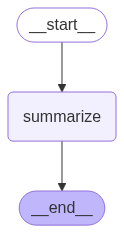

In [ ]:
workflow = StateGraph(AgentState)

# Let's add a node, which is the summarize function we defined before
workflow.add_node("summarize", summarize_step)

# Let's define Edges, which define how data flows between nodes
workflow.add_edge("summarize", END)
workflow.set_entry_point("summarize")
workflow.compile()

In [ ]:
sample_text = """
    Electric cars work by using electricity stored in a battery pack to power an electric motor, which drives the wheels.
    Unlike gasoline-powered vehicles that rely on internal combustion engines, electric vehicles (EVS) use electric motors that are more efficient and produce zero emissions during operation.
    When you press the accelerator, the battery sends power to the motor, which instantly provides torque to move the car.
    The battery is recharged by plugging the car into an external power source, such as a home charger or public charging station.
    Some electric cars also feature regenerative braking, which captures energy during braking and feeds it back into the battery to improve efficiency.
    """

# Let's compile the graph
graph = workflow.compile()

# Set up the initial state with the input text
initial_state = {
        "input_text": sample_text,
        "summary": ""}

# Run the graph
result = graph.invoke(initial_state)

# Get the summary from the result
summary = result["summary"]

# Print the result
print_markdown(summary)

Electric cars operate using electricity stored in batteries to power electric motors, providing efficient, zero-emission performance, and can be recharged via external power sources, while some models also utilize regenerative braking to enhance energy efficiency.

In [ ]:
response= client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{'role':'user','content':'Hi'}], # Changed from 'message' to 'messages'
    temperature=0.3
)
print(response.choices[0].message.content) # Changed from 'contant' to 'content'

Hello! How can I assist you today?


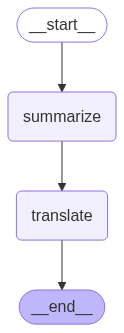

In [ ]:
class AgentState(TypedDict):
    input_text: str
    summary: str
    translated_summary: str


def translate_step(state: AgentState) -> AgentState:
    """Translate text"""

    # Initialize the OpenAI model and define the prompt
    llm = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=openai_api_key
    )
    prompt = f"Please translate from english to spanish: {state['summary']}"

    # Get the summary directly from the model
    result = llm.invoke([prompt])

    # Update the state with our summary
    return {
        "input_text": state["input_text"],  # Keep the original text
        "summary": state["summary"],  # Add the summary
        "translated_summary": result.content
    }


# Let's define a stategraph with the "AgentState" we defined earlier
workflow = StateGraph(AgentState)

# Let's add a node, which is the summarize function we defined before
workflow.add_node("summarize", summarize_step)

# Let's define Edges, which define how data flows between nodes
workflow.add_edge("summarize", "translate")

workflow.add_node("translate", translate_step)

workflow.set_entry_point("summarize")
workflow.compile()

In [ ]:
sample_text = """
    Electric cars are awesome! I love them so much! They work by using electricity stored in a battery pack to power an electric motor, which drives the wheels.
    Unlike gasoline-powered vehicles that rely on internal combustion engines, electric vehicles (EVS) use electric motors that are more efficient and produce zero emissions during operation.
    When you press the accelerator, the battery sends power to the motor, which instantly provides torque to move the car.
    The battery is recharged by plugging the car into an external power source, such as a home charger or public charging station.
    Some electric cars also feature regenerative braking, which captures energy during braking and feeds it back into the battery to improve efficiency.
    """

# Let's compile the graph
graph = workflow.compile()

# Set up the initial state with the input text
initial_state = {
        "input_text": sample_text,
        "summary": "",
        "translated_summary": ""}

# Run the graph
result = graph.invoke(initial_state)

# Get the summary from the result
summary = result["summary"]
translation = result["translated_summary"]

# Print the results with clear labels and spacing
print("=== Generated Summary ===")
print(summary)

print("\n=== Translated Summary ===")
print(translation)

=== Generated Summary ===
Electric cars are highly efficient vehicles powered by electric motors using stored battery energy, produce zero emissions, and can be recharged through external power sources, with some models featuring regenerative braking to enhance energy efficiency.

=== Translated Summary ===
Los coches eléctricos son vehículos altamente eficientes impulsados por motores eléctricos que utilizan energía de batería almacenada, producen cero emisiones y pueden recargarse a través de fuentes de energía externas, con algunos modelos que cuentan con frenos regenerativos para mejorar la eficiencia energética.


In [ ]:
tavily_api_key = os.environ["TAVILY_API_KEY"]
print(f"Tavily Key starts with: {tavily_api_key[:5]}...")

In [ ]:
llm = ChatOpenAI(model = "gpt-4.1-mini", temperature = 0, streaming = True)
print("LangChain OpenAI Chat Model configured.")

In [ ]:
class AgentState(TypedDict):
    # AgentState is the name of the dictionary (used to represent the agent's state in the workflow).
    # It has one key: "messages", which holds a list of messages (e.g., from the user, model, or tools).
    # BaseMessage is the type used to represent each message in that list.
    # operator.add tells LangGraph to append new messages to the list during execution.
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_search_tool = TavilySearchResults(max_results = 3)

# List of tools for this step
tools_list_single = [tavily_search_tool]